In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, Flatten, Lambda, Reshape, BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import random
import cv2
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError, Mean, binary_crossentropy, binary_accuracy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

In [2]:
try:
    import google.colab
    in_colab = True
except ImportError:
    in_colab = False

if in_colab:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.TPUStrategy(tpu)
    except ValueError:
        if 'GPU' in [gpu[-1] for gpu in tf.config.list_physical_devices('GPU')]:
            print('Running on Google Colab GPU')
        else:
            print('Not connected to a TPU or GPU runtime')

else:
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    try:
        if len(physical_devices):
            for gpu in physical_devices:
                tf.config.experimental.set_memory_growth(gpu, enable = True)
                print(f"Using local GPU: {gpu}")
            sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(log_device_placement = True))
        else:
            print("No local GPU found")
    except:
        print("Error Mounting a GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using local GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6



In [3]:
EPOCHS = 100
seed = 42

INPUT_SHAPE = (400, 600, 3)
IMAGE_SHAPE = (400, 600)
BATCH_SIZE = 4

In [4]:
base_directory = 'Data'
hires_folder = os.path.join(base_directory, 'high res')
lowres_folder = os.path.join(base_directory, 'low res')

data = pd.read_csv("Data/image_data.csv")
data['low_res'] = data['low_res'].apply(lambda x: os.path.join(lowres_folder, x))
data['high_res'] = data['high_res'].apply(lambda x: os.path.join(hires_folder, x))
#data.head()

# data = filter_df(data, viable_nums=["6"]) # For GAN

train_data, val_test_data = train_test_split(data, test_size=0.2, random_state=seed)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=seed)

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

train_hiresimage_generator = image_datagen.flow_from_dataframe(
    train_data,
    x_col='high_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

train_lowresimage_generator = image_datagen.flow_from_dataframe(
    train_data,
    x_col='low_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

val_hiresimage_generator = image_datagen.flow_from_dataframe(
    val_data,
    x_col='high_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

val_lowresimage_generator = image_datagen.flow_from_dataframe(
    val_data,
    x_col='low_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

test_hiresimage_generator = image_datagen.flow_from_dataframe(
    test_data,
    x_col='high_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

test_lowresimage_generator = image_datagen.flow_from_dataframe(
    test_data,
    x_col='low_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

train_generator = zip(train_lowresimage_generator, train_hiresimage_generator)
val_generator = zip(val_lowresimage_generator, val_hiresimage_generator)
test_generator = zip(test_lowresimage_generator, test_hiresimage_generator)

def imageGenerator(generator):
    for (low_res, hi_res) in generator:
        yield (low_res, hi_res)

train_samples = train_hiresimage_generator.samples
val_samples = val_hiresimage_generator.samples

train_img_gen = imageGenerator(train_generator)
val_img_gen = imageGenerator(val_generator)
test_img_gen = imageGenerator(test_generator)

Found 3009 validated image filenames.
Found 3009 validated image filenames.
Found 376 validated image filenames.
Found 376 validated image filenames.
Found 377 validated image filenames.
Found 377 validated image filenames.


In [5]:
train_samples = train_hiresimage_generator.samples
val_samples = val_hiresimage_generator.samples

train_img_gen = imageGenerator(train_generator)
val_img_gen = imageGenerator(val_generator)
test_img_gen = imageGenerator(test_generator)

In [13]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

def ms_ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim_multiscale(y_true, y_pred, max_val=1.0)

model1, model1_name = load_model("models/trained_conv_model.h5"), "conv_model"
model2, model2_name = load_model("models/trained_autoencoder.h5"), "autoencoder"
model3, model3_name = load_model("models/trained_unet.h5"), "unet"
model4, model4_name = load_model("models/trained_inception.h5"), "inception"
model5, model5_name = load_model("models/trained_inception_alt.h5"), "inception_alt"
model6, model6_name = load_model("models/trained_skip_model.h5"), "skip_model"
model7, model7_name = load_model("models/trained_skip_model_2.h5"), "skip_model_2"
model8, model8_name = load_model("models/trained_unet_ssim_loss.h5", custom_objects={'ssim_loss': ssim_loss}), "unet ssim"
model9, model9_name = load_model("models/trained_unet_ms_ssim_loss.h5", custom_objects={'ms_ssim_loss': ms_ssim_loss}), "unet ms-ssim"

models = [[model1, model1_name], [model2, model2_name], [model3, model3_name], [model4, model4_name], [model5, model5_name], [model6, model6_name], [model7, model7_name], [model8, model8_name], [model9, model9_name]]

In [7]:
# test_results = model.evaluate(test_img_gen, steps=test_hiresimage_generator.samples // BATCH_SIZE)
# print("Test Loss:", test_results[0])
# print("Test MAE:", test_results[1])

conv_model
1/1 [==============================] - 0s 50ms/step


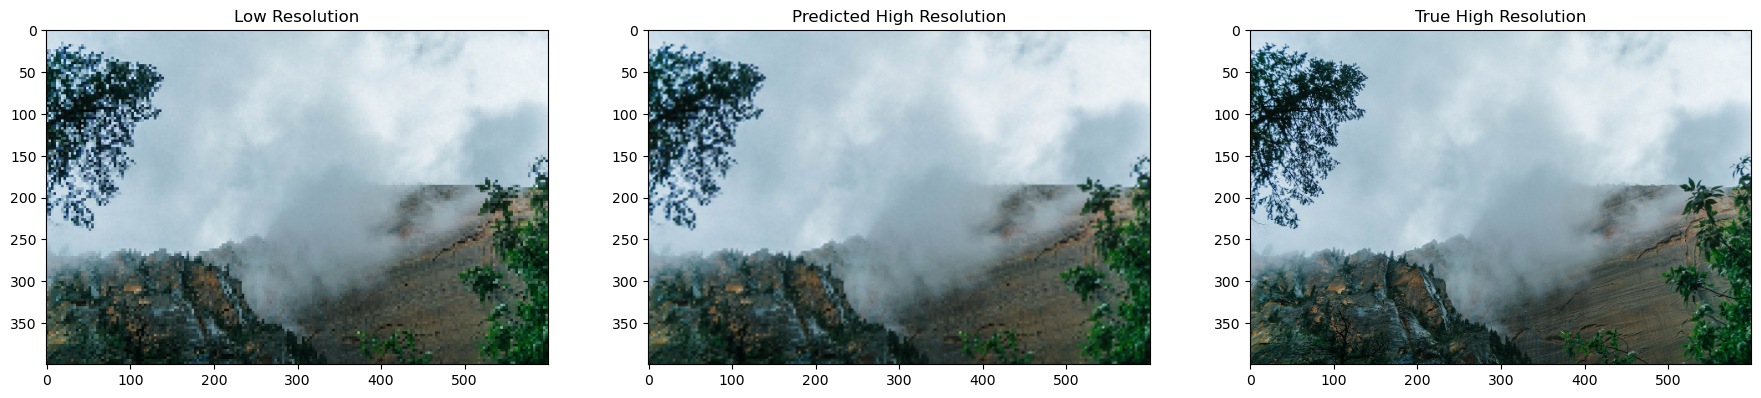

autoencoder
1/1 [==============================] - 0s 76ms/step


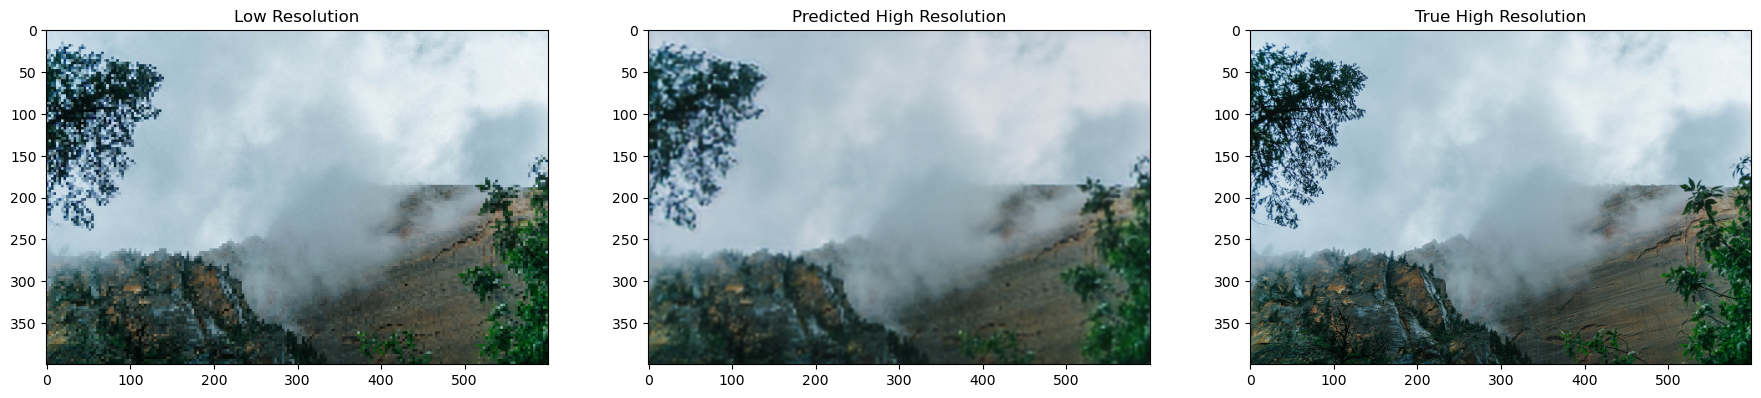

unet
1/1 [==============================] - 0s 92ms/step


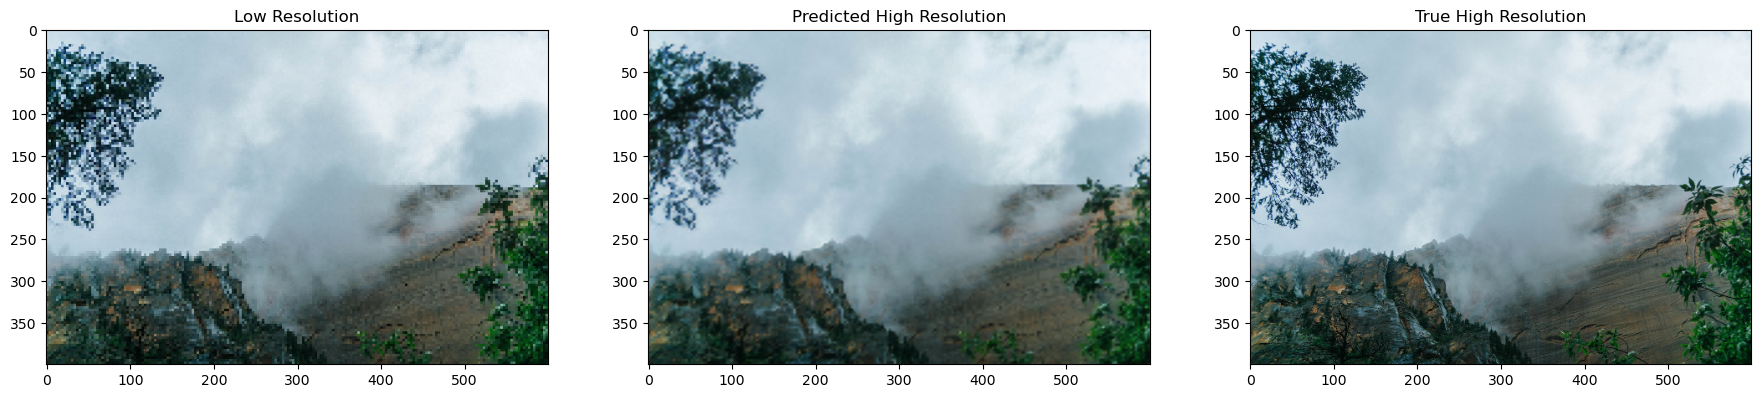

inception
1/1 [==============================] - 0s 97ms/step


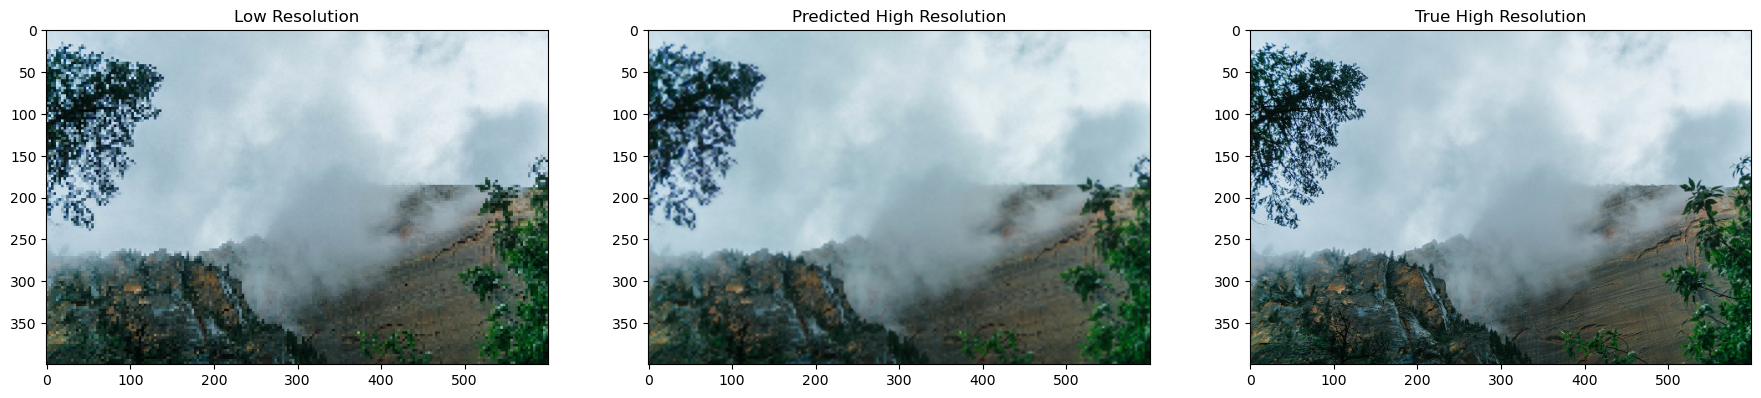

inception_alt
1/1 [==============================] - 0s 147ms/step


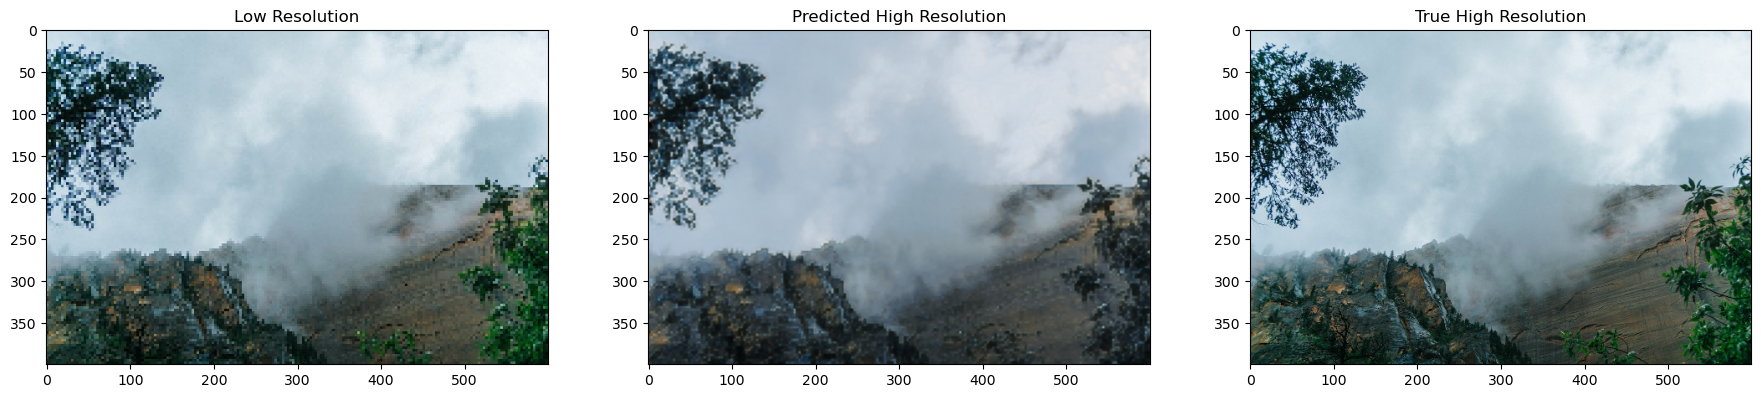

skip_model
1/1 [==============================] - 0s 67ms/step


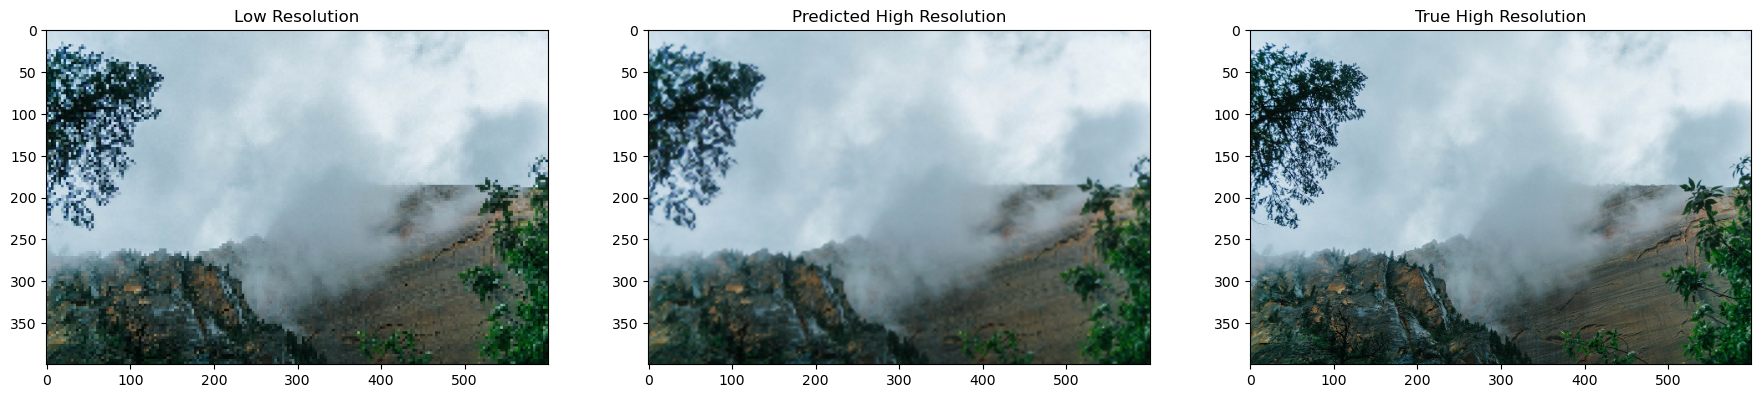

skip_model_2
1/1 [==============================] - 0s 82ms/step


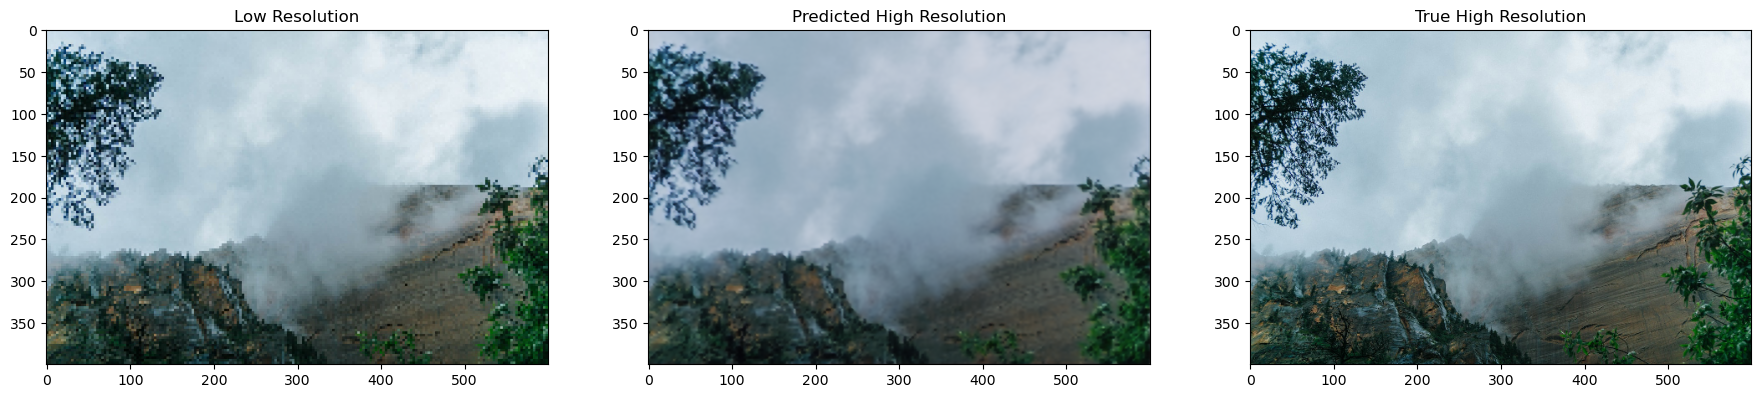

unet ssim
1/1 [==============================] - 0s 93ms/step


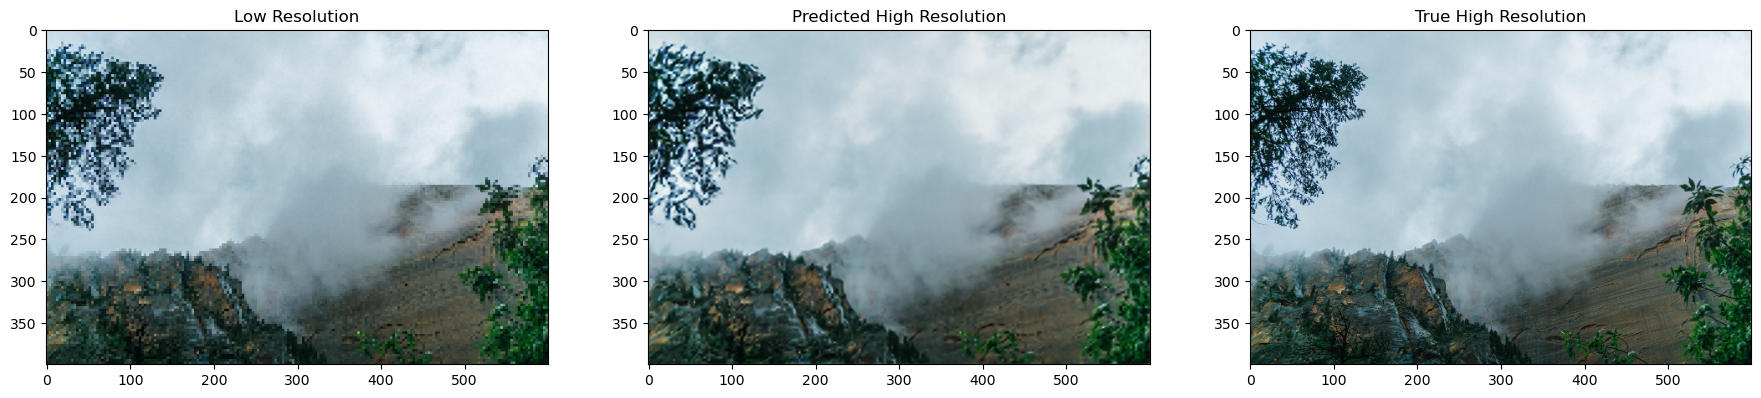

unet ms-ssim
1/1 [==============================] - 0s 93ms/step


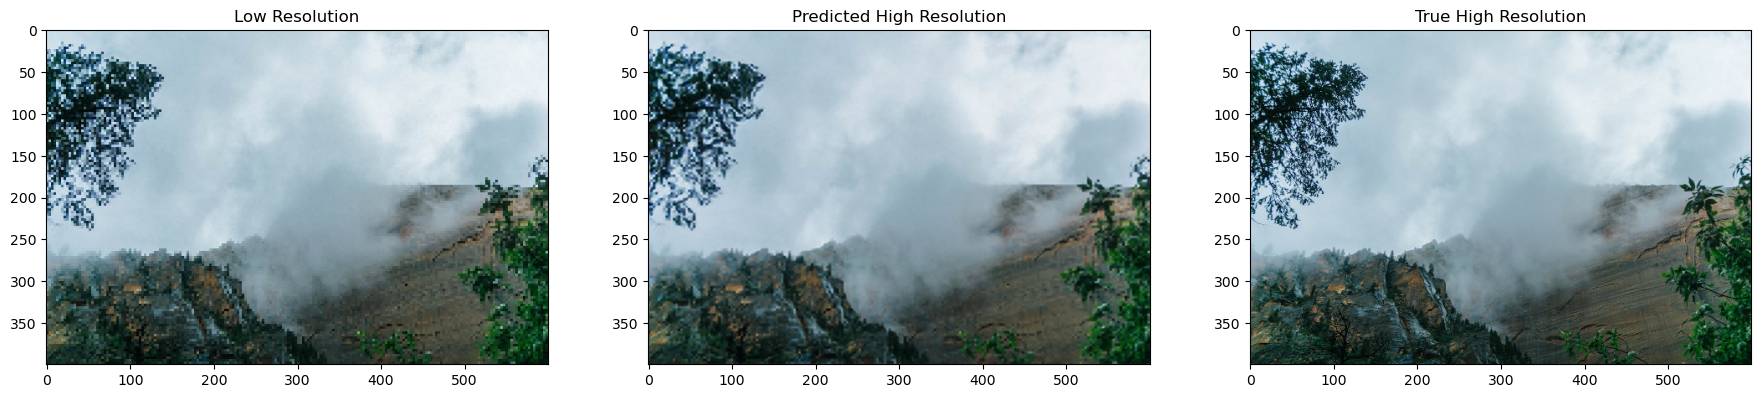

In [14]:
num_examples_to_visualize = 5

low_res, hi_res = next(test_img_gen)

for model, model_name in models:
    print(f"{model_name}")
    prediction = model.predict(low_res)
    
    if "inception" in model_name:
        prediction = prediction[0]

    plt.figure(figsize=(22, 14))

    plt.subplot(1, 3, 1)
    plt.imshow(low_res[0])
    plt.title("Low Resolution")

    plt.subplot(1, 3, 2)
    plt.imshow(prediction[0])
    plt.title("Predicted High Resolution")

    plt.subplot(1, 3, 3)
    plt.imshow(hi_res[0])
    plt.title("True High Resolution")

    plt.show()